#### Building GPT 

Based on: 
1) https://github.com/karpathy/nanoGPT
2) https://youtube.com/watch?v=kCc8FmEb1nY&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=7

We will be implementing 4 types of self-attention implementations
1) Barely an implementation of self-attention, averaging past context
2) implementation with matrix multiplication
3) adding softmax on top
    * Additionally, we implement variable embedding sizes and incorporating positional encoding
4) the real self-attention

In [6]:
# read it in to inspect it
with open('./Shakespeare.txt', 'r', encoding='utf-8') as f:
    text = f.read()
    
print("length of dataset in characters: ", len(text))

# let's look at the first 1000 characters
print(text[:1000])

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print("Unique Characters: " + ''.join(chars))
print("Vocab Size: " + str(vocab_size))

length of dataset in characters:  1115394

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hun

There is generally a trade off between Vocab Size and Sequence lengths, our vocabulary size is tiny since it is a character level vocabulary, but sequences turn out very large. There are many methods that bring out a better balance between the vocabulary and sequence lengths, but for simplicity we will keep the scheme that we have been using. 

in practice, each character in our set up is a token, thus they will be referred to as tokens from hereon. 

In [7]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [8]:
# let's now encode the entire text dataset and store it into a torch.Tensor
import torch # we use PyTorch: https://pytorch.org
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this

torch.Size([1115394]) torch.int64
tensor([ 0, 18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43,
        44, 53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52,
        63,  1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,
         1, 57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39,
        49,  6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15,
        47, 58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50,
        50,  1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1,
        58, 53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51,
        47, 57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43,
        42,  8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57,
        58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1,
        63, 53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56,
      

In [9]:
# Creating the dataset

n = int(0.9 * len(data))

train_data = data[:n]
val_data = data[n:]

# And dataloaders 

block_size = 8
x = train_data[:block_size]
y = train_data[1:block_size + 1]

for t in range(block_size):
    context = x[:t + 1]
    target = y[t]
    print(f"when input tensor is {context.tolist()}, target is {target}")

when input tensor is [0], target is 18
when input tensor is [0, 18], target is 47
when input tensor is [0, 18, 47], target is 56
when input tensor is [0, 18, 47, 56], target is 57
when input tensor is [0, 18, 47, 56, 57], target is 58
when input tensor is [0, 18, 47, 56, 57, 58], target is 1
when input tensor is [0, 18, 47, 56, 57, 58, 1], target is 15
when input tensor is [0, 18, 47, 56, 57, 58, 1, 15], target is 47


notice that we train on not only sequences of length n, but all the x <= n sequences. This is done, not only for computations reasons, but also to allow the model to learn how to make predictions on smaller sequences than n. 

In [10]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel
block_size = 8 # what is the maximum context length for predictions?

# number of input_examples = batch_size * block_size (4 * 8 = 32)

def get_batch(split):
    # Select the appropriate dataset based on the split parameter
    data = train_data if split == "train" else val_data

    # Generate a batch of random starting indices within the dataset
    ix = torch.randint(len(data) - block_size, (batch_size,))

    # Select a block of text of size block_size starting from each random index
    x = torch.stack([data[i:i+block_size] for i in ix])

    # Shift the selected block of text by one character to the right to create the target sequence
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch("train")
print(f"inputs:\nshape{xb.shape}\ndata: {xb}")
print(f"targets:\nshape{yb.shape}\ndata: {yb}")

inputs:
shapetorch.Size([4, 8])
data: tensor([[ 0, 24, 43, 58,  5, 57,  1, 46],
        [ 1, 44, 53, 56,  1, 58, 46, 39],
        [43, 52, 58,  1, 58, 46, 39, 58],
        [27, 25, 17, 27, 10,  0, 21,  1]])
targets:
shapetorch.Size([4, 8])
data: tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])


Let's start by quickly building a bigram model and training it

In [12]:
import torch
import torch.nn as nn
from torch.nn import functional as F

import matplotlib.pyplot as plt

torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a loockup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets = None):
        # idx and targets are both (B, T) tensor of ints
        logits = self.token_embedding_table(idx) # (B, T, C) = (4, 8 , vocab_size)
        
        if targets is None:
            loss = None
        else:
            # note that F.cross_entropy accepts inputs in shape (B, C, T)
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T) # can be as targets = targets.view(-1)
            
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the logits for the next token
            logits, loss = self(idx)
            # focus only on the last time step
            # (note that we are feeding the whole context each time, however we only care about the last prediction)
            # (this make doesn't make sense now, but the function will be modified later)
            logits = logits[:, -1, :] # Becomes (B, C) (get the last time step for each sequence)
            # apply softmax to convert to probabilities
            probs = F.softmax(logits, dim = -1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled token to the context
            idx = torch.cat((idx, idx_next), dim = 1) # (B, T + 1)
        return idx
    

m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)

print(f"logits shape: {logits.shape}")
print(f"loss: {loss} | we are expecting a loss of around {torch.log(torch.tensor(vocab_size))}")

logits shape: torch.Size([32, 65])
loss: 4.7389655113220215 | we are expecting a loss of around 4.174387454986572


In [13]:
idx = torch.zeros((1,1), dtype = torch.long)
generated = m.generate(idx, 100) # shape (1, 101)
print(decode(generated[0].tolist()))


Sr?qP-QWktXoL&jLDJgOLVz'RIoDqHdhsV&vLLxatjscMpwLERSPyao.qfzs$Ys$zF-w,;eEkzxjgCKFChs!iWW.ObzDnxA Ms$3


Training the bigram model

In [14]:
optimizer = torch.optim.AdamW(m.parameters(), lr = 1e-3)
batch_size = 32
lossi = []

for i in range(10000):
    # sample a batch of training data
    xb, yb = get_batch("train")

    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none = True)
    loss.backward()
    optimizer.step()

    lossi.append(loss.item())

print(f"loss: {loss.item()}")

loss: 2.5532305240631104


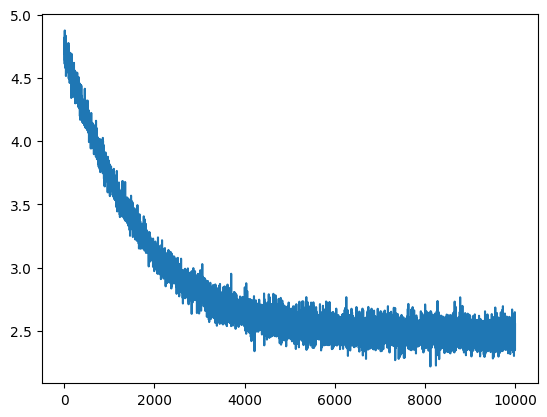

In [15]:
plt.plot(lossi)

In [16]:
# sampling from the model
idx = torch.zeros((1,1), dtype = torch.long)
generated = m.generate(idx, 400) # shape (1, 101)
print(decode(generated[0].tolist()))


Iyoteng h hasbe pave pirance
Rie hicomyonthar's
Plinseard ith henouratucenonthioneir thondy, y heltieiengerofo'dsssit ey
KIN d pe wither vouprrouthercc.
hathe; d!
My hind tt hinig t ouchos tes; st yo hind wotte grotonear 'so it t jod weancotha:
h hay.JUCle n prids, r loncave w hollular s O:
HIs; ht anjx?

DUThinqunt.

LaZAnde.
athave l.
KEONH:
ARThanco be y,-hedarwnoddy scar t tridesar, wnl'shenou


we can just as easily, port the bigram model to a .py file and summon it

In [19]:
!python bigram.py

^C


##### Version 1: Averaging Previous Token Embeddings

To predict the next token accurately, it's very useful if each token considers the context provided by all its predecessors. The self-attention mechanism facilitates this by allowing each token to interact directly with every previous token. One straightforward method to implement this is by averaging the embeddings of prior tokens. This approach simplifies the communication between tokens but comes with a tradeoff—it can lead to a loss of detailed spatial information, as the specific positions of tokens within the sequence are not clear. This method is effective for capturing general context, but it will overlook the exact order of tokens, leading to suboptimal performance.

In [20]:
torch.manual_seed(1337)
B, T, C = 4, 8, 2 # batch size, time, channels
x = torch.randn(B, T, C)
print(f"x shape: {x.shape}")

# We want x[b, t] = mean_(i<=t) x[b, i]
xbow = torch.zeros((B, T, C))
for b in range(B):
    for t in range(T):
        xprev = x[b, :t+1] # (t, C)
        xbow[b, t] = torch.mean(xprev, dim = 0) # average over time dimension (t)

x shape: torch.Size([4, 8, 2])


In [21]:
# Let's Check the first Batch
print(f"x[0]: {x[0]}")
print(f"xbow[0]: {xbow[0]}")

# the first row is the same 
print(x[0, 0] == xbow[0, 0])
# the second row is the average of the first two rows
print((x[0, 0] + x[0, 1]) / 2 == xbow[0, 1])

x[0]: tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643],
        [ 0.3612,  1.1679],
        [-1.3499, -0.5102],
        [ 0.2360, -0.2398],
        [-0.9211,  1.5433]])
xbow[0]: tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])
tensor([True, True])
tensor([True, True])


##### Version 2: Matrix Multiplication

To enhance efficiency, we can replace nested loops with matrix multiplication. This is achieved by multiplying the data matrix by a lower triangular matrix. This approach leverages the properties of linear algebra to ensure that each token is influenced only by preceding tokens, effectively maintaining the sequence's order while streamlining the computational process.

In [22]:
torch.manual_seed(42)
# lower triangular matrix of ones
a = torch.tril(torch.ones(3,3)) 
# make all rows sum to 1
a = a / torch.sum(a, 1, keepdim = True)
# create a random matrix
b = torch.randint(0, 10, (3, 2)).float() 

c = a @ b
print(f"a (shape = {a.shape}) =\n{a}")
print(f"b (shape = {b.shape}) =\n{b}")
print(f"c (shape = {c.shape}) =\n{c}")

a (shape = torch.Size([3, 3])) =
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
b (shape = torch.Size([3, 2])) =
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
c (shape = torch.Size([3, 2])) =
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


In [23]:
# We want x[b, t] = mean_(i<=t) x[b, i]
wei = torch.tril(torch.ones(T, T)) # (T, T)
# make all rows sum to 1
wei = wei / torch.sum(wei, 1, keepdim = True) # (T, T)
xbow2 = wei @ x # (T, T) @ (B, T, C) ----broadcasting----> (B, T, T) @ (B, T, C) ➡️ (B, T, C)

# check if xbow2 is the same as xbow
print(torch.allclose(xbow, xbow2, atol = 1e-7))

True


0.209729 M parameters
 step 0 | train loss: 4.4090 | val loss: 4.4038
 step 100 | train loss: 2.6517 | val loss: 2.6604
 step 200 | train loss: 2.5039 | val loss: 2.5026
 step 300 | train loss: 2.4024 | val loss: 2.4111
 step 400 | train loss: 2.3420 | val loss: 2.3542
 step 500 | train loss: 2.2987 | val loss: 2.3059
 step 600 | train loss: 2.2390 | val loss: 2.2619
 step 700 | train loss: 2.2038 | val loss: 2.2211
 step 800 | train loss: 2.1629 | val loss: 2.1864
 step 900 | train loss: 2.1256 | val loss: 2.1533
 step 1000 | train loss: 2.0873 | val loss: 2.1280
 step 1100 | train loss: 2.0720 | val loss: 2.1124
 step 1200 | train loss: 2.0420 | val loss: 2.0878
 step 1300 | train loss: 2.0200 | val loss: 2.0635
 step 1400 | train loss: 2.0102 | val loss: 2.0633
 step 1500 | train loss: 1.9883 | val loss: 2.0434
 step 1600 | train loss: 1.9615 | val loss: 2.0379
 step 1700 | train loss: 1.9424 | val loss: 2.0214
 step 1800 | train loss: 1.9238 | val loss: 2.0167
 step 1900 | train lo

##### Version 3: Introducing Softmax in Matrix Operations

We enhance our matrix manipulation by applying softmax to a lower triangular matrix, modified to replace upper values with negative infinity. This focuses the model on prior tokens by normalizing weights into a probability distribution. When multiplied with the data matrix, this method yields a contextually weighted sequence. The softmax transformation ensures that each token's influence is adjusted dynamically, improving the representational accuracy of sequential data. The effectiveness of this approach is verified using torch.allclose, comparing the new outputs to established benchmarks.

In [24]:
tril = torch.tril(torch.ones(T, T))
# we start with zeros, but later these will be replaced with data dependent values (affinities)
wei = torch.zeros((T, T))
# masked_fill: for all elements where tril == 0, replace with float("-inf")
wei = wei.masked_fill(tril == 0, float("-inf"))
print(f"wei:\n{wei}")
wei = F.softmax(wei, dim = -1)
print(f"wei:\n{wei}")
xbow3 = wei @ x

# check if xbow3 is the same as xbow
print(torch.allclose(xbow, xbow3, atol = 1e-7))

wei:
tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])
wei:
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])
True

##### Refining the Bigram Language Model with Variable Embedding Sizes

In our latest update to the Bigram Language Model, we introduce a variable embedding size, allowing for greater flexibility in handling different dimensions of token representations. By removing the vocab_size parameter from the constructor and defining it globally, we streamline the model's interface. The embedding layer will be adjusted to output a size of n_embed rather than the fixed vocabulary size. To connect these embeddings to our desired output dimension, a linear layer that outputs to the vocab_size will have to be added. This structure aims to enhances the model's ability to learn more nuanced features from the data while maintaining direct compatibility with the vocabulary size through the final output layer.

In [25]:
class BigramLanguageModel(nn.Module):
    # no need to pass vocab_size as an argument, since it is a global variable in this file
    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a loockup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        # the output layer is a linear layer with vocab_size outputs
        self.lm_head = nn.Linear(n_embed, vocab_size)

    def forward(self, idx, targets = None):
        # idx and targets are both (B, T) tensor of ints
        token_emb = self.token_embedding_table(idx) # (B, T, C) = (4, 8 , vocab_size)
        logits = self.lm_head(token_emb) # (B, T, vocab_size) = (4, 8, vocab_size)
    

##### Incorporating Positional Encoding

To further enhance the model, we can integrate a positional encoding layer. This addition assigns a unique embedding to each position in a sequence, ensuring that the model recognizes not only the content of tokens but also their specific positions within sequences. The positional embeddings are summed with the token embeddings, giving the input representation spatial information before it is processed by the subsequent layers. This method is particularly effective in maintaining the sequential integrity of the data, providing the model with essential temporal cues that significantly improve the accuracy and relevance of its predictions.

In [26]:
class BigramLanguageModel(nn.Module):
    # no need to pass vocab_size as an argument, since it is a global variable in this file
    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a loockup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        # each position is also associated with an embedding vector
        self.position_embedding_table = nn.Embedding(block_size, n_embed)
        # the output layer is a linear layer with vocab_size outputs
        self.lm_head = nn.Linear(n_embed, vocab_size)

    def forward(self, idx, targets = None):
        B, T = idx.shape
        # idx and targets are both (B, T) tensor of ints
        token_emb = self.token_embedding_table(idx) # (B, T, C) = (4, 8 , vocab_size)
        pos_emb = self.position_embedding_table(torch.arange(T, device = idx.device)) # (T, C) = (8, vocab_size)
        # x has the token identities + the position embeddings
        x = token_emb + pos_emb # (B, T, C) = (4, 8, vocab_size)
        logits = self.lm_head(x) # (B, T, vocab_size) = (4, 8, vocab_size)

##### Version 4: Self-Attention

In the self-attention framework, each token (also referred to as a node) generates three distinct vectors to facilitate a nuanced interaction within the sequence:

* Query: Represents what the token is actively seeking within the sequence.
* Key: Describes the unique characteristics that the token possesses.
* Value: Contains the actual information or message the token can impart if selected.

The mechanism begins by calculating affinities, or weights (wei), by taking the dot product of a token's Query vector with all Key vectors across the sequence. A high alignment between a Query and a Key results in a high affinity value, indicating a strong relevance between the tokens, thus highlighting segments of the sequence that are particularly significant for learning.

Rather than directly applying these weights to the original tokens, they are used to scale the Value vectors. This approach ensures that the model emphasizes and learns from the most contextually relevant information contained within the sequence. This method is key to enhancing the model's ability to understand and generate sequences based on the internal dynamics of the data.

In [27]:
torch.manual_seed(1337)
B, T, C = 4, 8, 32 # batch, time, channels

# x is private information of each token
x = torch.randn(B, T, C)

# single Head perform self-attention
head_size = 16
key = nn.Linear(C, head_size, bias = False)
query = nn.Linear(C, head_size, bias = False)
value = nn.Linear(C, head_size, bias = False)


k = key(x) # (B, T, head_size) = (4, 8, 16)
q = query(x) # (B, T, head_size) = (4, 8, 16)

# now every token in every batch is associated with a key and a query (in parallel), no communication between tokens has happened yet

wei = q @ k.transpose(-2, -1) # (B, T, head_size) @ (B, head_size, T) = (B, T, T)
tril = torch.tril(torch.ones(T, T))
# wei are no longer zeros, but data dependent values (affinities)
# wei = torch.zeros((T, T))
wei = wei.masked_fill(tril == 0, float("-inf"))
wei = F.softmax(wei, dim = -1)

print(f"wei[0]: {wei[0]}")

# multiply with value instead of x
v = value(x) # (B, T, head_size) = (4, 8, 16)
out = wei @ v # (B, T, T) @ (B, T, head_size) = (B, T, head_size)
# out = wei @ x

wei[0]: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
        [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
        [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
        [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],
       grad_fn=<SelectBackward0>)


### Notes About Self-Attention

- **Mechanism Overview**:
  - Self-attention acts as a mechanism where nodes (tokens) in a directed graph observe and aggregate information from each other.
  - It aggregates this information as a weighted sum, with weights determined by the data-dependent relevance of each node.

- **Spatial Independence**:
  - Self-attention processes a set of vectors without inherent spatial relationships, hence the necessity for positional encoding to provide context about the sequence order.

- **Batch Processing**:
  - Each example within a batch is processed independently, ensuring no cross-communication between different sequence examples in the batch.

- **Encoder vs. Decoder Attention Blocks**:
  - **Encoder Attention**: Allows all tokens to interact freely; commonly used in applications like translation and sentiment analysis.
  - **Decoder Attention**: Uses triangular masking to restrict attention flow, ensuring that each token can only attend to previous tokens (autoregressive property). This is typical in tasks like language modeling.

- **Self-Attention vs. Cross-Attention**:
  - **Self-Attention**: Both keys and values are derived from the same input as the queries.
  - **Cross-Attention**: While queries are derived from one source (e.g., the decoder), keys and values are sourced from another (e.g., the encoder).

- **Scaled Dot-Product Attention**:
  - Involves scaling the attention weights (`wei`) by the square root of the dimensionality of the key vectors to maintain unit variance. This prevents softmax from becoming too peaky at initialization, ensuring a more uniform distribution of attention weights and avoiding extreme focus on a single vector unless warranted by high relevance.

These mechanisms ensure that self-attention models can adaptively highlight and integrate relevant information from sequences based on the internal dynamics of the data, making it highly effective for a variety of complex sequence modeling tasks.


In [28]:
# Scaled Attention
k = torch.randn(B, T, head_size)
q = torch.randn(B, T, head_size)

print("Unscaled Attention")
wei = q @ k.transpose(-2, -1)
print(f"var(k) = {torch.var(k)}")
print(f"var(q) = {torch.var(q)}")
print(f"var(wei) = {torch.var(wei)}")

print("\nScaled Attention")
wei = q @ k.transpose(-2, -1) * (head_size ** -0.5)
print(f"var(k) = {torch.var(k)}")
print(f"var(q) = {torch.var(q)}")
print(f"var(wei) = {torch.var(wei)}")

Unscaled Attention
var(k) = 1.044861912727356
var(q) = 1.0700464248657227
var(wei) = 17.46897315979004

Scaled Attention
var(k) = 1.044861912727356
var(q) = 1.0700464248657227
var(wei) = 1.0918108224868774


We will first add a single attention head and then once we are done, we will move on to adding several of them. 

##### Adding a single Self Attention Head to the Bigram Language Model

In [29]:
# Making the Head Class
class Head(nn.Module):
    """ one head of self attention """
    
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embed, head_size, bias = False)
        self.query = nn.Linear(n_embed, head_size, bias = False)
        self.value = nn.Linear(n_embed, head_size, bias = False)
        # since tril isn't a parameter, we register it as a buffer
        self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))
    
    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x) # (B, T, C)
        q = self.query(x) # (B, T, C)

        # compute attention scores (affinities)
        wei = q @ k.transpose(-2, -1) * (C ** -0.5) # (B, T, C) @ (B, C, T) = (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0 , float("-inf")) # (B, T, T)
        wei = F.softmax(wei, dim = -1) # (B, T, T)

        # perform weighted aggregation of the values
        v = self.value(x) # (B, T, C)
        out = wei @ v # (B, T, T) @ (B, T, C) = (B, T, C)
        return out

Now we can modify the bigram language model. we will be adding "Head" to the BigramLanguageModel class and forward pass, as well as cropping idx for "generate" function. This cropping is done in order to keep idx.shape <= block_size, as we are using positional embedding

In [30]:
# Adding Head to the BigramLanguageModel

# super simple bigram model
class BigramLanguageModel(nn.Module):
    # no need to pass vocab_size as an argument, since it is a global variable in this file
    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a loockup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        # each position is also associated with an embedding vector
        self.position_embedding_table = nn.Embedding(block_size, n_embed)
        # a single head of self attention
        self.sa_head = Head(n_embed)
        # the output layer is a linear layer with vocab_size outputs
        self.lm_head = nn.Linear(n_embed, vocab_size)

    def forward(self, idx, targets = None):
        B, T = idx.shape
        # idx and targets are both (B, T) tensor of ints
        token_emb = self.token_embedding_table(idx) # (B, T, C) = (4, 8 , vocab_size)
        pos_emb = self.position_embedding_table(torch.arange(T, device = idx.device)) # (T, C) = (8, vocab_size)
        # x has the token identities + the position embeddings
        x = token_emb + pos_emb # (B, T, C) = (4, 8, vocab_size)
        # feed the input to the self attention head
        x = self.sa_head(x) # (B, T, C) = (4, 8, vocab_size)
        logits = self.lm_head(x) # (B, T, vocab_size) = (4, 8, vocab_size)

        if targets is None:
            loss = None
        else:
            # note that F.cross_entropy accepts inputs in shape (B, C, T)
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T) # can be as targets = targets.view(-1)
            
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:] # (B, T)
            # get the logits for the next token
            logits, loss = self(idx_cond)
            # focus only on the last time step
            # (note that we are feeding the whole context each time, however we only care about the last prediction)
            # (this make doesn't make sense now, but the function will be modified later)
            logits = logits[:, -1, :] # Becomes (B, C) (get the last time step for each sequence)
            # apply softmax to convert to probabilities
            probs = F.softmax(logits, dim = -1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled token to the context
            idx = torch.cat((idx, idx_next), dim = 1) # (B, T + 1)
        return idx

Now multi-headed attention is much easier to implement, the bulk of the work is done. we will add a new class "MultiHeadAttention", which will summon "head"-s inside it. 

Before:

self.sa_head = Head(n_embed)

After:

self.sa_heads = MultiHeadAttention(num_head = 4, head_size = n_embed // 4)

In [31]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_head, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_head)])
    
    def forward(self, x):
        # concatenate them into the channel dimension
        return torch.cat([h(x) for h in self.heads], dim = -1)

let's also implement feedforward layer while at it

In [ ]:
class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity """
    def __init__(self, n_embed):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embed, n_embed),
            nn.ReLU(),
        )
    
    def forward(self, x):
        return self.net(x)

Construct Transformer blocks

In [32]:
class Block(nn.Module):
    """ Transformer Block: Communication followed by Computation """

    def __init__(self, n_embed, n_head):
        """ n_embed: embedding dimension
            n_head: number of heads in the multi-head attention
        """
        super().__init__()
        head_size = n_embed // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embed)
    
    def forward(self, x):
        x = self.sa(x)
        x = self.ffwd(x)
        return x

Final grooming

In [33]:
class Block(nn.Module):
    """ Transformer Block: Communication followed by Computation """

    def __init__(self, n_embed, n_head):
        """ n_embed: embedding dimension
            n_head: number of heads in the multi-head attention
        """
        super().__init__()
        head_size = n_embed // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embed)
    
    def forward(self, x):
        # residual connection (add the input to the output)
        x = x + self.sa(x)
        x = x + self.ffwd(x)
        return x
    
# Multi Head Attention Class
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_head, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_head)])
        # linear transformation to the output of the multi-head attention as projection back to the residual pathway
        self.proj = nn.Linear(n_embed, n_embed)
    
    def forward(self, x):
        # out is the outptu of the multi-head attention
        out =  torch.cat([h(x) for h in self.heads], dim = -1)
        # apply a linear layer to the concatenated output
        out = self.proj(out)
        return out

# Feed Forward Class
class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity """
    def __init__(self, n_embed):
        super().__init__()
        self.net = nn.Sequential(
            # multiply by 4 to follow the original implementation
            nn.Linear(n_embed, 4 * n_embed),
            nn.ReLU(),
            nn.Linear(n_embed * 4, n_embed),
        )
    
    def forward(self, x):
        return self.net(x)

Now we add BatchNormalization

In [34]:
# after normalizing the rows (and removing the buffers too)
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum = 0.1):
        self.eps = eps
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

    def __call__(self, x):
        xmean = x.mean(1, keepdim= True)
        xvar = x.var(1, keepdim= True)
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

torch.manual_seed(1337)
module = BatchNorm1d(100)
x = torch.randn(32, 100)
x = module(x)
x.shape

# columns are not normalized now
print(f"mean of first column: {x[:, 0].mean():.4f} | std of first column: {x[:, 0].std():.4f}")
# rows are normalized now
print(f"mean of first row: {x[0, :].mean():.4f} | std of first row: {x[0, :].std():.4f}")

mean of first column: 0.1469 | std of first column: 0.8803
mean of first row: -0.0000 | std of first row: 1.0000


In [35]:
class Block(nn.Module):
    """ Transformer Block: Communication followed by Computation """

    def __init__(self, n_embed, n_head):
        """ n_embed: embedding dimension
            n_head: number of heads in the multi-head attention
        """
        super().__init__()
        head_size = n_embed // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embed)
        # ln1 is applied directly on input before the multi-head attention
        self.ln1 = nn.LayerNorm(n_embed)
        # ln2 is applied directly on the output of the multi-head attention before the feed-forward layer
        self.ln2 = nn.LayerNorm(n_embed)
    
    def forward(self, x):
        # residual connection (add the input to the output)
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x
    
class BigramLanguageModel(nn.Module):
    # no need to pass vocab_size as an argument, since it is a global variable in this file
    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a loockup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        # each position is also associated with an embedding vector
        self.position_embedding_table = nn.Embedding(block_size, n_embed)
        # transformer blocks
        self.blocks = nn.Sequential(
                Block(n_embed, n_head = 4),
                Block(n_embed, n_head = 4),
                Block(n_embed, n_head = 4),
                # add layernorm here
                nn.LayerNorm(n_embed),
        )
        self.lm_head = nn.Linear(n_embed, vocab_size)

Now, we scale up the model

In [36]:
# super simple bigram model
class BigramLanguageModel(nn.Module):
    # no need to pass vocab_size as an argument, since it is a global variable in this file
    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a loockup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        # each position is also associated with an embedding vector
        self.position_embedding_table = nn.Embedding(block_size, n_embed)
        # transformer blocks
        self.blocks = nn.Sequential(*[Block(n_embed, n_head = 4) for _ in range(n_layer)])
        # Remember to add it in forward too
        self.ln_f = nn.LayerNorm(n_embed)
        self.lm_head = nn.Linear(n_embed, vocab_size)

In [37]:
!python bigram.py

^C
